In [1]:
import itertools
import re

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import math
from math import floor
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
#DATA PRE-PROCESSING

In [3]:
df = pd.read_json("products_all.json", lines=True)
df = df.rename(columns={'n_reviews': 't_reviews', 'm_reviews': 'n_reviews'})

In [4]:
dr = df[['url','reviews_url']]
df = df.drop(['url', 'reviews_url', 'discount_price'], 1)

df = df[df['t_reviews']>0]

In [5]:
df.loc[df['genres'].isna(), 'genres'] = df['tags']
df['genres'].dropna()
df['genres'] = [str(x) for x in df['genres']]
df['specs'] = [str(x) for x in df['specs']]
df['tags'] = [str(x) for x in df['tags']]
df['platform'] = [str(x) for x in df['platform']]
df['release_date'] = [str(x) for x in df['release_date']]

In [6]:
df.loc[df['title']== 'D']
#df.head()

,id,title,developer,publisher,release_date,genres,tags,t_reviews,p_reviews,n_reviews,early_access,price,sentiment,platform,specs,metascore


In [7]:
df['price'] = df['price'].apply(pd.to_numeric, errors='coerce').fillna(0).astype(float).dropna()
df = df.drop(['metascore'], 1)
#df.head()

In [8]:
#Function to calculate game rating based on steamDB's formula
def ratings(row):
    pos = row['p_reviews']
    average = pos / row['t_reviews']
    
    rating = average - (average*0.5) * 2**(-math.log10(row['t_reviews']+1))
    return rating * 100

#Separating genres into columns, values 0s and 1s
def genres_split(d):
    cols = ['Action', 'Adventure', 'Casual', 'Indie', 'RPG', 'Racing', 'Simulation', 'Sports', 'Strategy']
    g_cols = []
    for i in sorted(cols):
        col = i.lower().replace(' ','_')
        g_cols.append(col)
        d[col] = np.where(d['genres'].str.contains(i), 1, 0)

    g = d[g_cols].sum(axis=1)
    d = d[g > 0].copy()
    
    return d


#Adding columns for single_player and multi_player categories
def play_split(d):
    tags_col = ['Multiplayer', 'Massively Multiplayer']
    specs_col = ['Online PvP', 'Cross-Platform Multiplayer']
    #splitting on basis of multiplayer tags
    for i, j in zip(tags_col, specs_col):
        d.loc[d['tags'].str.contains(i), 'multi_player'] = 1
        d.loc[d['specs'].str.contains(j), 'multi_player'] = 1
    
    #splitting on basis of singleplayer tags
    d.loc[d['tags'].str.contains('Singleplayer'), 'single_player'] = 1
    d.loc[d['specs'].str.contains('Single-player'), 'single_player'] = 1
    
    #filling NaN values with 0
    d['single_player'] = d['single_player'].fillna(0)
    d['multi_player'] = d['multi_player'].fillna(0)
    return d

def platform(d):
    os = ['mac', 'win', 'linux']
    for i in os:
        d.loc[d['platform'].str.contains(i), i] = 1
    for i in os:
        d[i] = d[i].fillna(0)
    return d

In [9]:
#Removing DLCs and demos from dataset
df.loc[df['specs'].str.contains('Downloadable Content|Game demo'), 'specs'] = np.nan
df = df.dropna(subset=['specs'])

#Replacing NaN values from sentiments to 'Less Reviews'
df['sentiment'] = df['sentiment'].replace(np.nan, 'Not_Found')

#Calculate ratings based on SteamDB's forumla
df['rating'] = df.apply(ratings, axis=1)

#Separating genres into columns, values 0s and 1s
df = genres_split(df)
del df['genres']

#Extracting Release Year from Date of Release
df['release_year'] = df['release_date'].str.extract(r'(\d{4})')
df = df[pd.notnull(df['release_year'])]
df['release_year'] = [int(x) for x in df['release_year']]

#Confine dataset to prices below USD$100
df.loc[df.price > 100, 'price'] = np.nan
df = df.dropna(subset=['price'])

#Categorizing games based on price, 'Free To Play' and 'Paid'
df['type'] = 'Free To Play'
df.loc[df.price > 0, 'type'] = 'Paid'

#Rearranging columns
r_col = ['id', 'title', 'developer', 'publisher', 'release_date', 'release_year', 'rating', 't_reviews', 'p_reviews', 'n_reviews', 'price', 'type', 'sentiment', 'platform', 'specs', 'tags', 'early_access', 'action', 'adventure', 'casual', 'indie', 'rpg', 'racing', 'simulation', 'sports', 'strategy']
df = df[r_col]

#Adding columns for single_player and multi_player categories
df = play_split(df)
df['single_player'] = [int(x) for x in df['single_player']]
df['multi_player'] = [int(x) for x in df['multi_player']]

#Splitting platforms
df = platform(df)
del df['platform']

#Create category column based on type of game (single/multi player)
df.loc[df['single_player']==1, 'category'] = 'Single Player'
df.loc[df['multi_player']==1, 'category'] = 'Multi Player'
df = df.dropna(subset=['category'])

#Creating platform_support column based on platforms
df.loc[df['mac']==1, 'platform_support'] = 'Mac'
df.loc[df['win']==1, 'platform_support'] = 'Windows'
df.loc[df['linux']==1, 'platform_support'] = 'Linux'
df.loc[(df['mac']==1) & (df['linux']==1), 'platform_support'] = 'Mac+Linux'
df.loc[(df['win']==1) & (df['linux']==1), 'platform_support'] = 'Win+Linux'
df.loc[(df['mac']==1) & (df['win']==1), 'platform_support'] = 'Win+Mac'
df.loc[(df['mac']==1) & (df['linux']==1) & (df['win']==1), 'platform_support'] = 'Win+Mac+Linux'
df = df.dropna(subset=['platform_support'])

#Some games do not have developer tags, while some have missing Publisher tags
df.loc[df['developer']==np.nan, 'developer'] = df['publisher']
df.loc[df['publisher']==np.nan, 'publisher'] = df['developer']

#Dropping values with NaN
df = df.dropna(subset=['developer', 'publisher'])

#Resetting Index
df=df.sort_values('id', ascending=True)
df.reset_index(drop=True, inplace=True)

In [10]:
colors_duo = ['#1C387B', '#45ACBF']
colors_set = ['#184D68', '#31809F', '#8fba25', '#d9f895', '#FB9C6C', '#D55121']

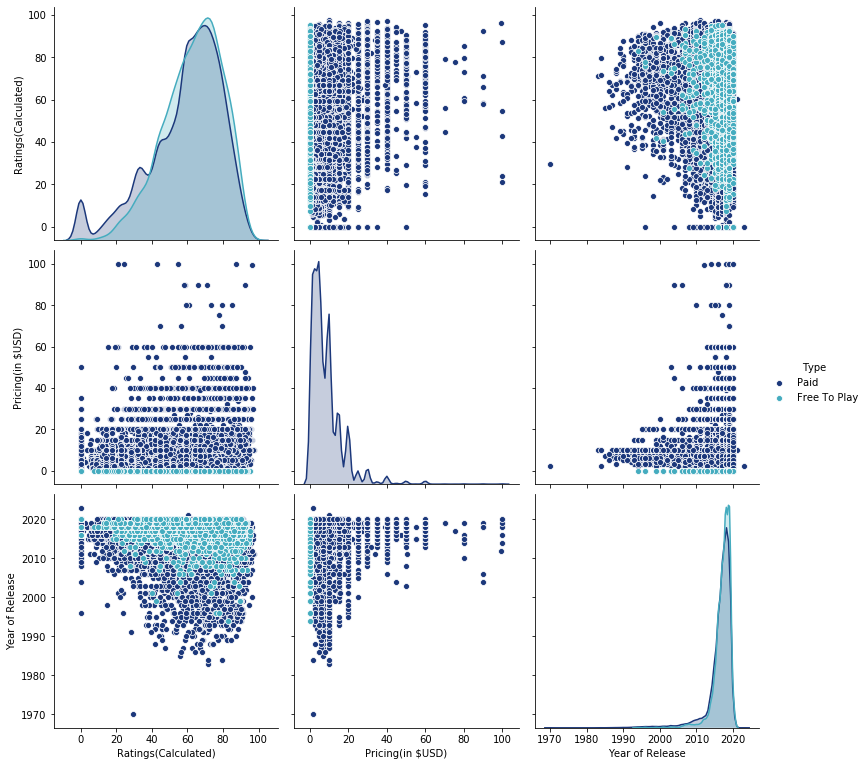

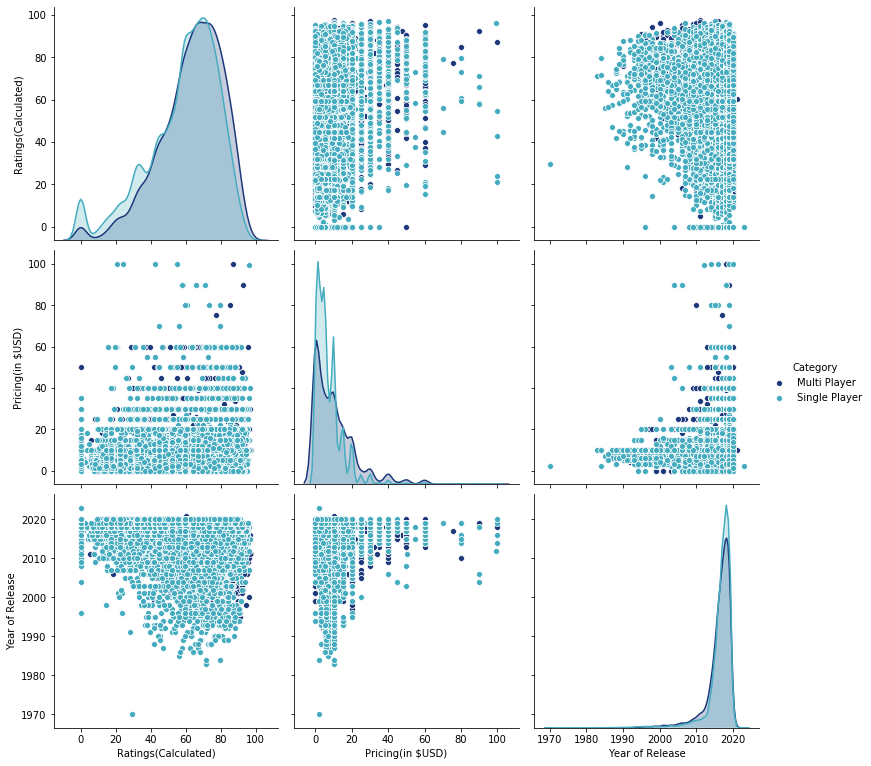

In [11]:
#PairPlot Graph on type
ds = pd.DataFrame(zip(df['rating'], df['price'], df['release_year'], df['type']), columns=['Ratings(Calculated)', 'Pricing(in $USD)', 'Year of Release', 'Type'])
sns.pairplot(ds, hue='Type', height=3.5, palette=colors_duo)


ds = pd.DataFrame(zip(df['rating'], df['price'], df['release_year'], df['category']), columns=['Ratings(Calculated)', 'Pricing(in $USD)', 'Year of Release', 'Category'])
sns.pairplot(ds, hue='Category', height=3.5, palette=colors_duo)
plt.show()

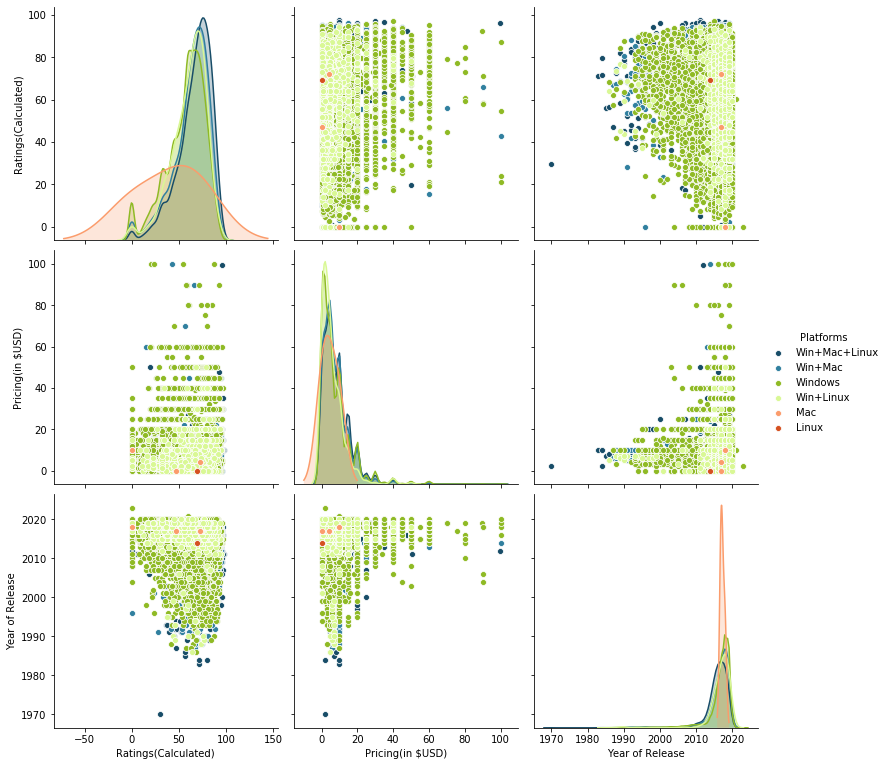

In [12]:
#PairPlot Graph
ds = pd.DataFrame(zip(df['rating'], df['price'], df['release_year'], df['platform_support']), columns=['Ratings(Calculated)', 'Pricing(in $USD)', 'Year of Release', 'Platforms'])
sns.pairplot(ds, hue='Platforms', height=3.5, palette=colors_set)
plt.show()

In [13]:
def decade(x):
    return str(floor(x/10)*10)+"s"

In [14]:
dz = pd.DataFrame(zip(df['rating'], df['release_year'], df['category'], df['platform_support'], df['type']), columns=['rating', 'release_year', 'category', 'platforms', 'type'])
dz['decade'] = dz['release_year'].apply(decade)
dz = dz.sort_values('release_year', ascending=True)

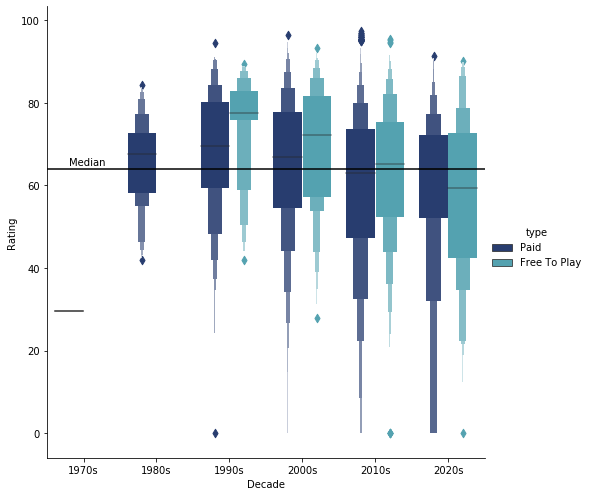

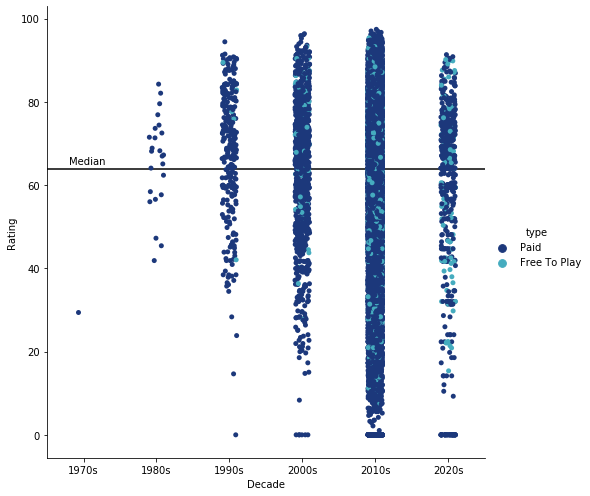

In [15]:
sns.catplot("decade", "rating", "type", data=dz, kind="boxen", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
sns.catplot("decade", "rating", "type", data=dz, kind="strip", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
plt.show()

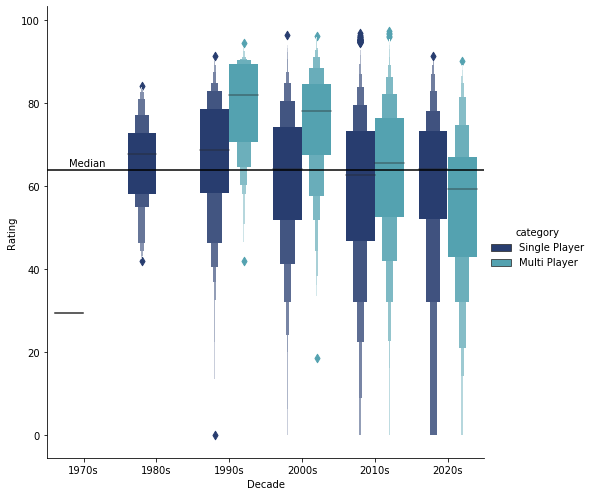

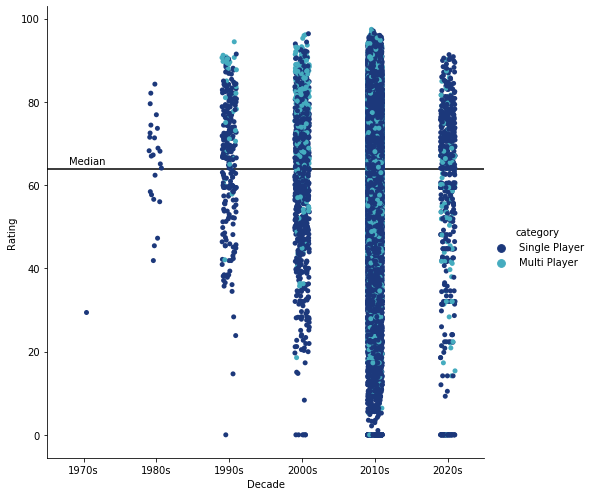

In [16]:
sns.catplot("decade", "rating", "category", data=dz, kind="boxen", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
sns.catplot("decade", "rating", "category", data=dz, kind="strip", height=7, palette=colors_duo).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
plt.show()

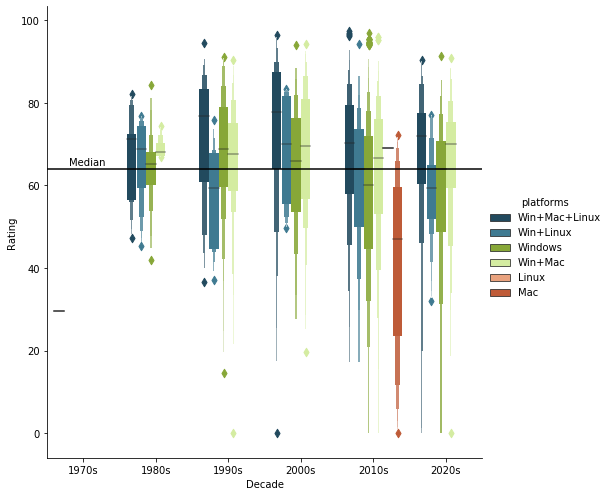

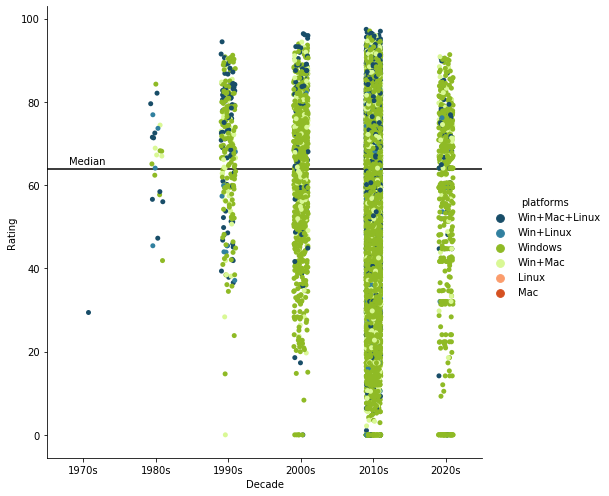

In [17]:
sns.catplot("decade", "rating", "platforms", data=dz, kind="boxen", height=7, palette=colors_set).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
sns.catplot("decade", "rating", "platforms", data=dz, kind="strip", height=7, palette=colors_set).set_axis_labels("Decade", "Rating")
plt.axhline(dz.rating.median(), color='black')
plt.text(-0.2, dz.rating.median()+1, 'Median')
plt.show()

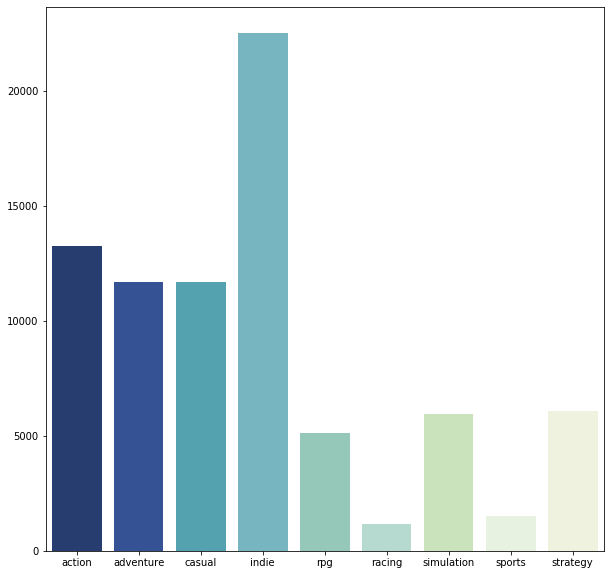

In [18]:
#Genre Frequency Count
col_genres = df.columns[-16:-7]
colors = ['#2A692D', '#317B35', '#388E3C', '#3FA044', '#8BC34A','#97C95D', '#DCE775', '#BFD962', '#FFF59D', '#FFF8B7', '#0099CC']
colors_b = ['#1C387B','#254ba5','#45ACBF','#6bbdcc','#8CD1BB','#b0e0d1','#CAEAB5','#e6f5dd','#f2f5dd']
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=col_genres ,y=df[col_genres].sum(), ax=ax, palette = colors_b)
plt.show()

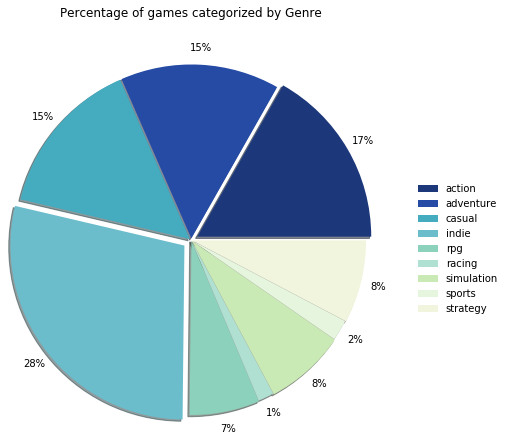

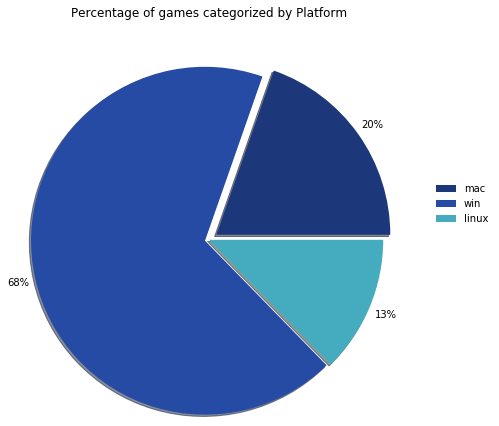

In [19]:
sizes = []
for x in df[col_genres].sum():
    sizes.append(x)

plat = df.columns[-5:-2]
sizes_p = []
for y in df[plat].sum():
    sizes_p.append(y)

fig1, ax1 = plt.subplots()
explode = (0.08, 0.02, 0.02, 0.1, 0.01, 0, 0.01, 0, 0.01)
ax1.pie(sizes, explode=explode, autopct='%1.0f%%', colors = colors_b, shadow=True, pctdistance=1.1, radius=2)
ax1.legend(labels = col_genres, frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title("Percentage of games categorized by Genre", y=1.5, x=0.5)

fig, ax2 = plt.subplots()
explode = (0.1, 0.05 ,0)
ax2.pie(sizes_p, explode=explode, autopct='%1.0f%%', colors = colors_b, shadow=True, pctdistance=1.1, radius=2)
ax2.legend(labels = plat, frameon=False, bbox_to_anchor=(1.5, 0.8))
plt.title("Percentage of games categorized by Platform", y=1.5, x=0.5)
plt.show()

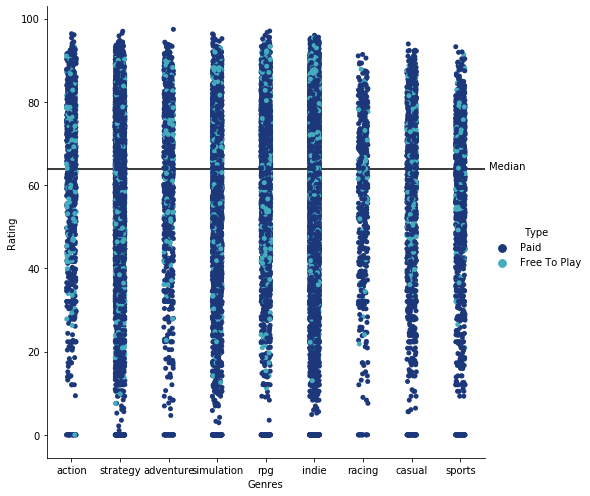

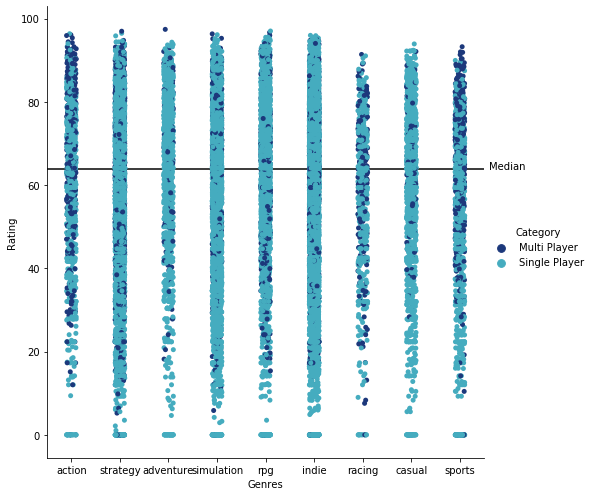

In [20]:
#Graph between rating and genres
for x in col_genres:
    df.loc[df[x].isin(['1']), 'genres'] = x

dx = pd.DataFrame(zip(df['rating'], df['genres'], df['category'], df['type']), columns=['Rating', 'Genres', 'Category','Type'])

sns.catplot('Genres', 'Rating', 'Type', data=dx, kind="strip", height=7, palette=colors_duo).set_axis_labels("Genres", "Rating")
plt.axhline(dx.Rating.median(), color='black')
plt.text(8.6, dx.Rating.median()-0.2, 'Median')

sns.catplot('Genres', 'Rating', 'Category', data=dx, kind="strip", height=7, palette=colors_duo).set_axis_labels("Genres", "Rating")
plt.axhline(dx.Rating.median(), color='black')
plt.text(8.6, dx.Rating.median()-0.2, 'Median')
plt.show()

In [21]:
#Including single_player and multi_player into genres
col_genres_1 = df.columns[-17:-6]

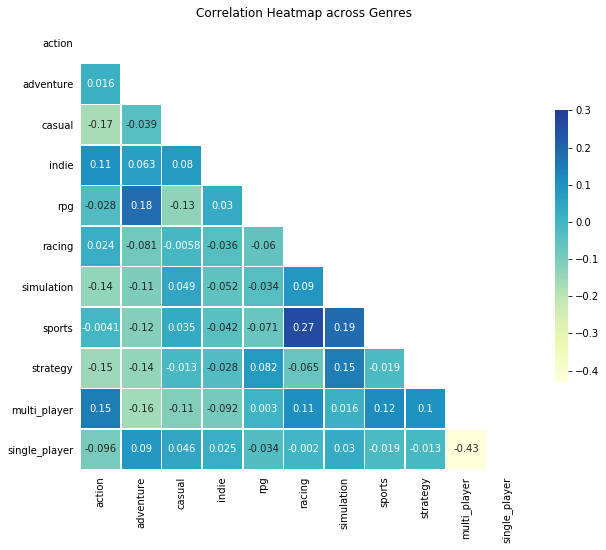

In [22]:
#Plotting correlation heatmap across Genres
corr = df[col_genres_1].corr()
#sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))
mask = np.triu(np.ones_like(corr, dtype=np.bool))
cmap = "YlGnBu"
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=True, labelbottom=True)
plt.title("Correlation Heatmap across Genres")
plt.show()


In [24]:
def dev_rating(d):
    
    release_count = stats.zscore(d.release_count**(1/2))
    p_ratings = np.log10(d.p_reviews)
    p_ratings[np.isinf(p_ratings)]=0
    p_ratings = stats.zscore(p_ratings)
    t_ratings = stats.zscore(np.log10(d.t_reviews))
    avg_rating = stats.zscore(d.average_rating)
    
    scores = (.1*release_count + .8*avg_rating + .3*p_ratings + .3*t_ratings) / 5
        
    return scores

dev = df.copy()
dev['release_count'] = 1
dev = dev.pivot_table(index='developer', values=['release_count', 'rating', 'p_reviews', 't_reviews', 'price'], 
                      aggfunc={'release_count': np.sum, 
                                'rating': np.mean,
                                'p_reviews': np.sum,
                                't_reviews': np.sum,
                                'price': np.mean}).rename({'price': 'average_price', 'rating': 'average_rating'}, axis=1)

dev['dev_rating'] = dev_rating(dev)
dev = dev.sort_values(by='dev_rating', ascending=False)
d_col = ['release_count', 'p_reviews', 't_reviews', 'average_price', 'average_rating', 'dev_rating']
dev = dev[d_col]
dev.head()

,release_count,p_reviews,t_reviews,average_price,average_rating,dev_rating
developer,,,,,,
Valve,20,5979746,6735063,6.892500,86.296070,0.974333
Re-Logic,1,403375,412944,9.990000,96.686791,0.768997
Facepunch Studios,4,814753,902962,18.740000,85.423952,0.757645
Klei Entertainment,6,204683,212843,17.823333,88.707234,0.732204
ConcernedApe,1,204656,209791,14.990000,96.332804,0.731547
